# Advanced Regression Predict

## Introduction

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

### Problem statement 
Providing an accurate and robust solution using machine learning to create effective marketing tools that give companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.


 ## Start Comet experiment

In [44]:
import comet_ml

In [45]:
# comet
from comet_ml import Experiment

In [ ]:
experiment = Experiment(api_key= 'nMFyxVc83DoLqA49L7VFRRs6w', project_name = 'Classification_AE1')

First we need to load the libraries we are going to use throughout the notebook.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB


# Accuracy Scores
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
%matplotlib inline
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Data Cleaning
import emoji
from bs4 import BeautifulSoup
import re
import itertools
import string

# Any results you write to the current directory are saved as output.

Loading the data.

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
tweetid = train['tweetid']

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is primarily used to see what data can reveal beyond the formal modeling or hypothesis testing task and provides a better understanding of data set variables and the relationships between them.

The first step is to create a copy of the train dataframe for the EDA to ensure that the original dataframe is preserved. 

In [12]:
train_data = train.copy()

Let's have a look at the raw data  

In [41]:
#Looking at the train and test data
print(train_data.shape)
print(test.shape)

display(train_data.head())
display(test.head())

percent_duplicates = round((1-(train_data['message'].nunique()/len(train_data['message'])))*100,2)
print('Duplicated tweets in train data:')
print(percent_duplicates,'%')

(15819, 3)
(10546, 2)


,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


Duplicated tweets in train data:
10.05 %


At first glance we can see that our data is still in its raw Twitter format, with mentiond and hashtags

### Statistical Summary

Let's now gather some statistical information on our train data

In [7]:
#look at column names
train_data.columns

Index(['sentiment', 'message', 'tweetid'], dtype='object')

In [8]:
# Shape of the dataset
train_data.shape

(15819, 3)

In [9]:
# dataframe information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [10]:
# Checking for missing values
train_data.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

There are no null values in our dataset

In [10]:
# Checking whether a character is white-space character or not
print(len(train_data['message']))
print(sum(train_data['message'].apply(lambda x: x.isspace())))

15819
0


In [11]:
# Looking at the how the messages are distributed across the sentiment
train_data.describe()

,tweetid,sentiment
count,15819.000000,15819.000000
mean,501719.433656,0.917504
std,289045.983132,0.836537
min,6.000000,-1.000000
25%,253207.500000,1.000000
50%,502291.000000,1.000000
75%,753769.000000,1.000000
max,999888.000000,2.000000


In [12]:
##see statistics for non-numerical columns
train_data.describe(include=['object'])

,message
count,15819
unique,14229
top,RT @StephenSchlegel: she's thinking about how ...
freq,307


In [13]:
# Looking at the numbers of possible classes in our sentiment
train_data['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

In [14]:
##see statistics for categorical features
train_data['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [15]:
##See percentage for categorical features
train_data['sentiment'].value_counts(normalize = True) * 100

 1    53.922498
 2    23.010304
 0    14.874518
-1     8.192680
Name: sentiment, dtype: float64

The weights of each categorical feature further confirm that the positive sentiments are the most popular in our train dataset. 

### Visualization

Next we visualize....

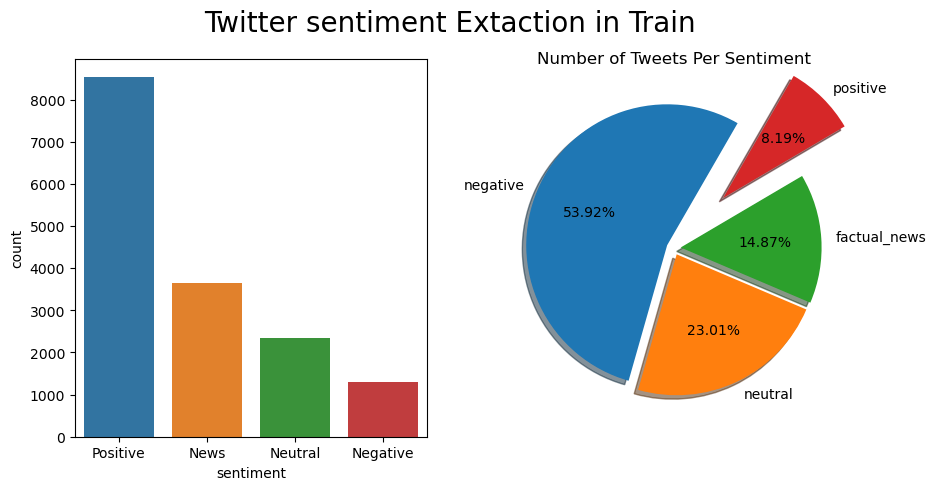

In [29]:
# Displaying target distribution.
working_df = train_data.copy()

# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]
labels = ['negative', 'neutral','factual_news', 'positive']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=100)
sns.countplot(x='sentiment' ,data = working_df, ax=axes[0])
plt.title('Number of Tweets Per Sentiment')
axes[1].pie(train_data['sentiment'].value_counts(),
            labels= labels,
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0.05, 0.05, 0.5),
            startangle=60)
fig.suptitle('Twitter sentiment Extaction in Train', fontsize=20)
plt.show()

From the distribution we are able to see that our data has a largest count of positive sentiments.The factual news has the 2nd largest and the least is the negative sentiment count.

There is clear imbalance in the data. Imbalanced data occurs when the number of observations across different class labels are unevenly distributed.

Let's now have a look the message length by sentiment, as well as the average length of a message per sentiment.

C:\Users\msntu\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\msntu\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\msntu\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

Text(0, 0.5, 'Density')

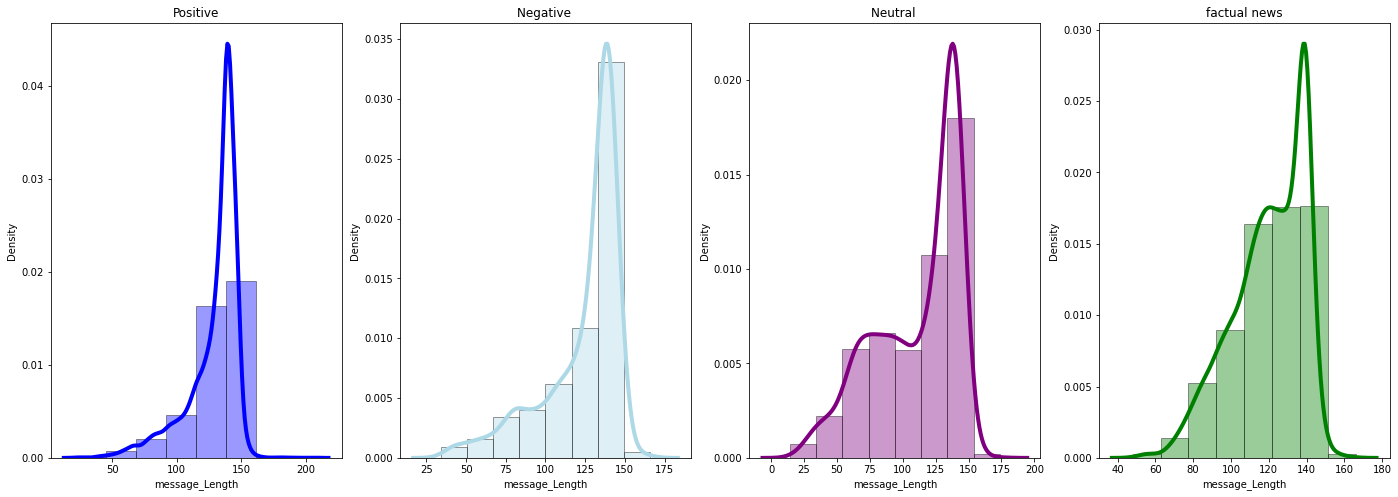

In [38]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(24,8))

#For Positive 
sns.distplot(train_data[train_data['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(train_data[train_data['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'lightblue', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(train_data[train_data['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'purple',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For factual news
sns.distplot(train_data[train_data['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('factual news')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')





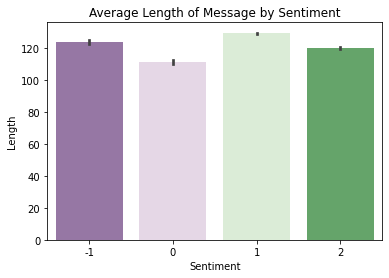

In [35]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=train_data['message'].apply(len) ,data = train_data, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

In the above two sets of plots we can visualise that both negative and postive tweets have roughly the highest average length of tweets, with Positive having a slightly higher average.

We will visualise whether a tagged user has any relation to the sentiment, and which users are most popular in each sentiment.

In [64]:
# Extracting Users in a column
train_data['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in train_data.message]

In [65]:
# Generating Counts of users
counts = train_data[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [66]:
# Top 5 most popular
counts.head()

,users,message
3410,@StephenSchlegel,307
3270,@SenSanders,243
6182,@realDonaldTrump,143
448,@BernieSanders,121
612,@CNN,106


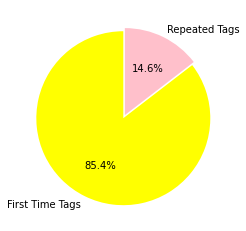

In [67]:
# checking the numerical distribution
values = [sum(np.array(counts['message']) == 1)/len(counts['message']), sum(np.array(counts['message']) != 1)/len(counts['message'])]
labels = ['First Time Tags', 'Repeated Tags']
colors = ['yellow', "pink"]
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0), colors=colors)
plt.show()

14.6% of the tweets are users tagged more than once. 


Knowing who is tagged on a tweet may increase the chance of the model to predict the correct sentiment of the tweet. **please try elaborate a bit more on the second sentence, and how it relates. perhaps something like "bellow we analyze the popularity by sentiment", just so it's clear which figure to look at when reading this sentence**

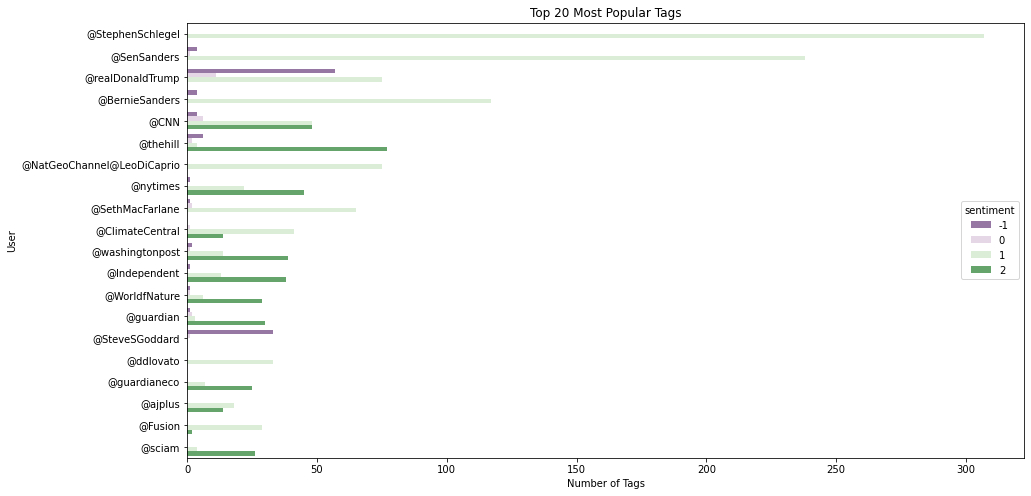

In [68]:
# Analysis of most popular tags, sorted by populariy
plt.figure(figsize=(15,8))
sns.countplot(y="users", hue="sentiment", data=train_data, palette='PRGn',
              order=train_data.users.value_counts().iloc[:20].index) 


plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

## Data Preprocessing
### ???

Now that we've gathered some insight from the EDA, let us use some of the insight we've gathered to clean our data. 

For our train dataset we will be implementing the following steps:
* removing the web-urls
* making everything lower case
* removing hashtags
* removing RTs
* lemmatization
* removing punctuation



### Text Cleaning

Step 1: Removing web-urls

In [188]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r''
train_data['message'] = train_data['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [189]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def word_lemma(words, lemmatizer):
    
    lemma = [lemmatizer.lemmatize(word) for word in words]
    return ''.join([l for l in lemma])

In [190]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer('english')
def word_stemmer(words, stemmer):
    return [stemmer.stem(word) for word in words]

In [191]:
import string

#Function to remove punctuations and numbers
def remove_punctuation_numbers(post):
    punc_numbers = string.punctuation + '0123456789'
    return ''.join([l for l in post if l not in punc_numbers])

In [192]:
def strip_accents(text):
    if 'ø' in text or  'Ø' in text:
        #Do nothing when finding ø 
        return text   
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)


In [211]:
#Clean the text

#Create a function to clean the tweets
def cleanTxt(text):
    #text = re.sub(r'@[A-Za-z0-9]+', '', text) # Removing mentions
    text = re.sub(r'#', '', text) # Removing the '#' symbol
    text = re.sub(r'RT[\s]+', '', text) #Removing RT
    #text = re.sub(r'https:+', '', text) # Remove the hyper link  
    #text = strip_accents(text) # remove non ascii characters
    text = text.lower() # Make text lowercase
    #text = word_lemma(text, lemmatizer)
    text = word_stemmer(text, stemmer)
    text = remove_punctuation_numbers(text) # Remove punctuation and numbers
    return text

In [194]:
#Clening the text
train_data['message'] = train_data['message'].apply(cleanTxt)

In [195]:
train_data.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt rawstory researchers say we have three year...,698562
3,1,todayinmaker wired was a pivotal year in the...,573736
4,1,rt soynoviodetodas its and a racist sexist cl...,466954


###  Word frequency
Creating separate dataframes to store the 25 most frequent words and their respective frequencies for each class. Once this information has been extracted we will use these words to create wordclouds for each class.

Word clouds are a popular approach in nlp tasks, here they help us visualize and gain a better understanding of what is being said in each class. ???

In [23]:
def frequency(tweet):
    
    """
    This function determines the frequency of each word in a collection of tweets 
    and stores the 25 most frequent words in a dataframe, 
    sorted from most to least frequent
    
    Input: 
    tweet: original tweets
           datatype: 'str'
           
    Output: 
    frequency: dataframe containing the top 25 words 
               datatype: dataframe          
    """
    
    # Count vectorizer excluding english stopwords
    cv = CountVectorizer(stop_words='english')
    words = cv.fit_transform(tweet)
    
    # Count the words in the tweets and determine the frequency of each word
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Create a dataframe to store the top 25 words and their frequencies
    frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])
    frequency = frequency.head(25)
    
    return frequency

# Extract the top 25 words in each class
positive_frequency = frequency(train_data['message'][train_data['sentiment']== 1])
negative_frequency = frequency(train_data['message'][train_data['sentiment']== -1])
news_frequency = frequency(train_data['message'][train_data['sentiment']== 2])
neutral_frequency = frequency(train_data['message'][train_data['sentiment']== 0])

In [26]:
# Extract the words in the tweets for the pro and anti climate change classes 
negative_words = ' '.join([text for text in negative_frequency['word']])
positive_words = ' '.join([text for text in positive_frequency['word']])
news_words = ' '.join([text for text in news_frequency['word']])
neutral_words = ' '.join([text for text in neutral_frequency['word']])

# Create wordcloud for the anti climate change class
negative_wordcloud = WordCloud(width=800, 
                           height=500, 
                           random_state=110, 
                           max_font_size=110, 
                           background_color='white',
                           colormap="Reds").generate(negative_words)

# Create wordcolud for the pro climate change class
positive_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=73, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Greens").generate(positive_words)

# Create wordcolud for the news climate change class
news_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=0, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Blues").generate(news_words)

# Create wordcolud for the neutral climate change class
neutral_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=10, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Oranges").generate(neutral_words)

positive_frequency.tail()

,word,freq
20,husband,312
21,stephenschlegel,307
22,sjofonã,307
23,epa,290
24,fight,288


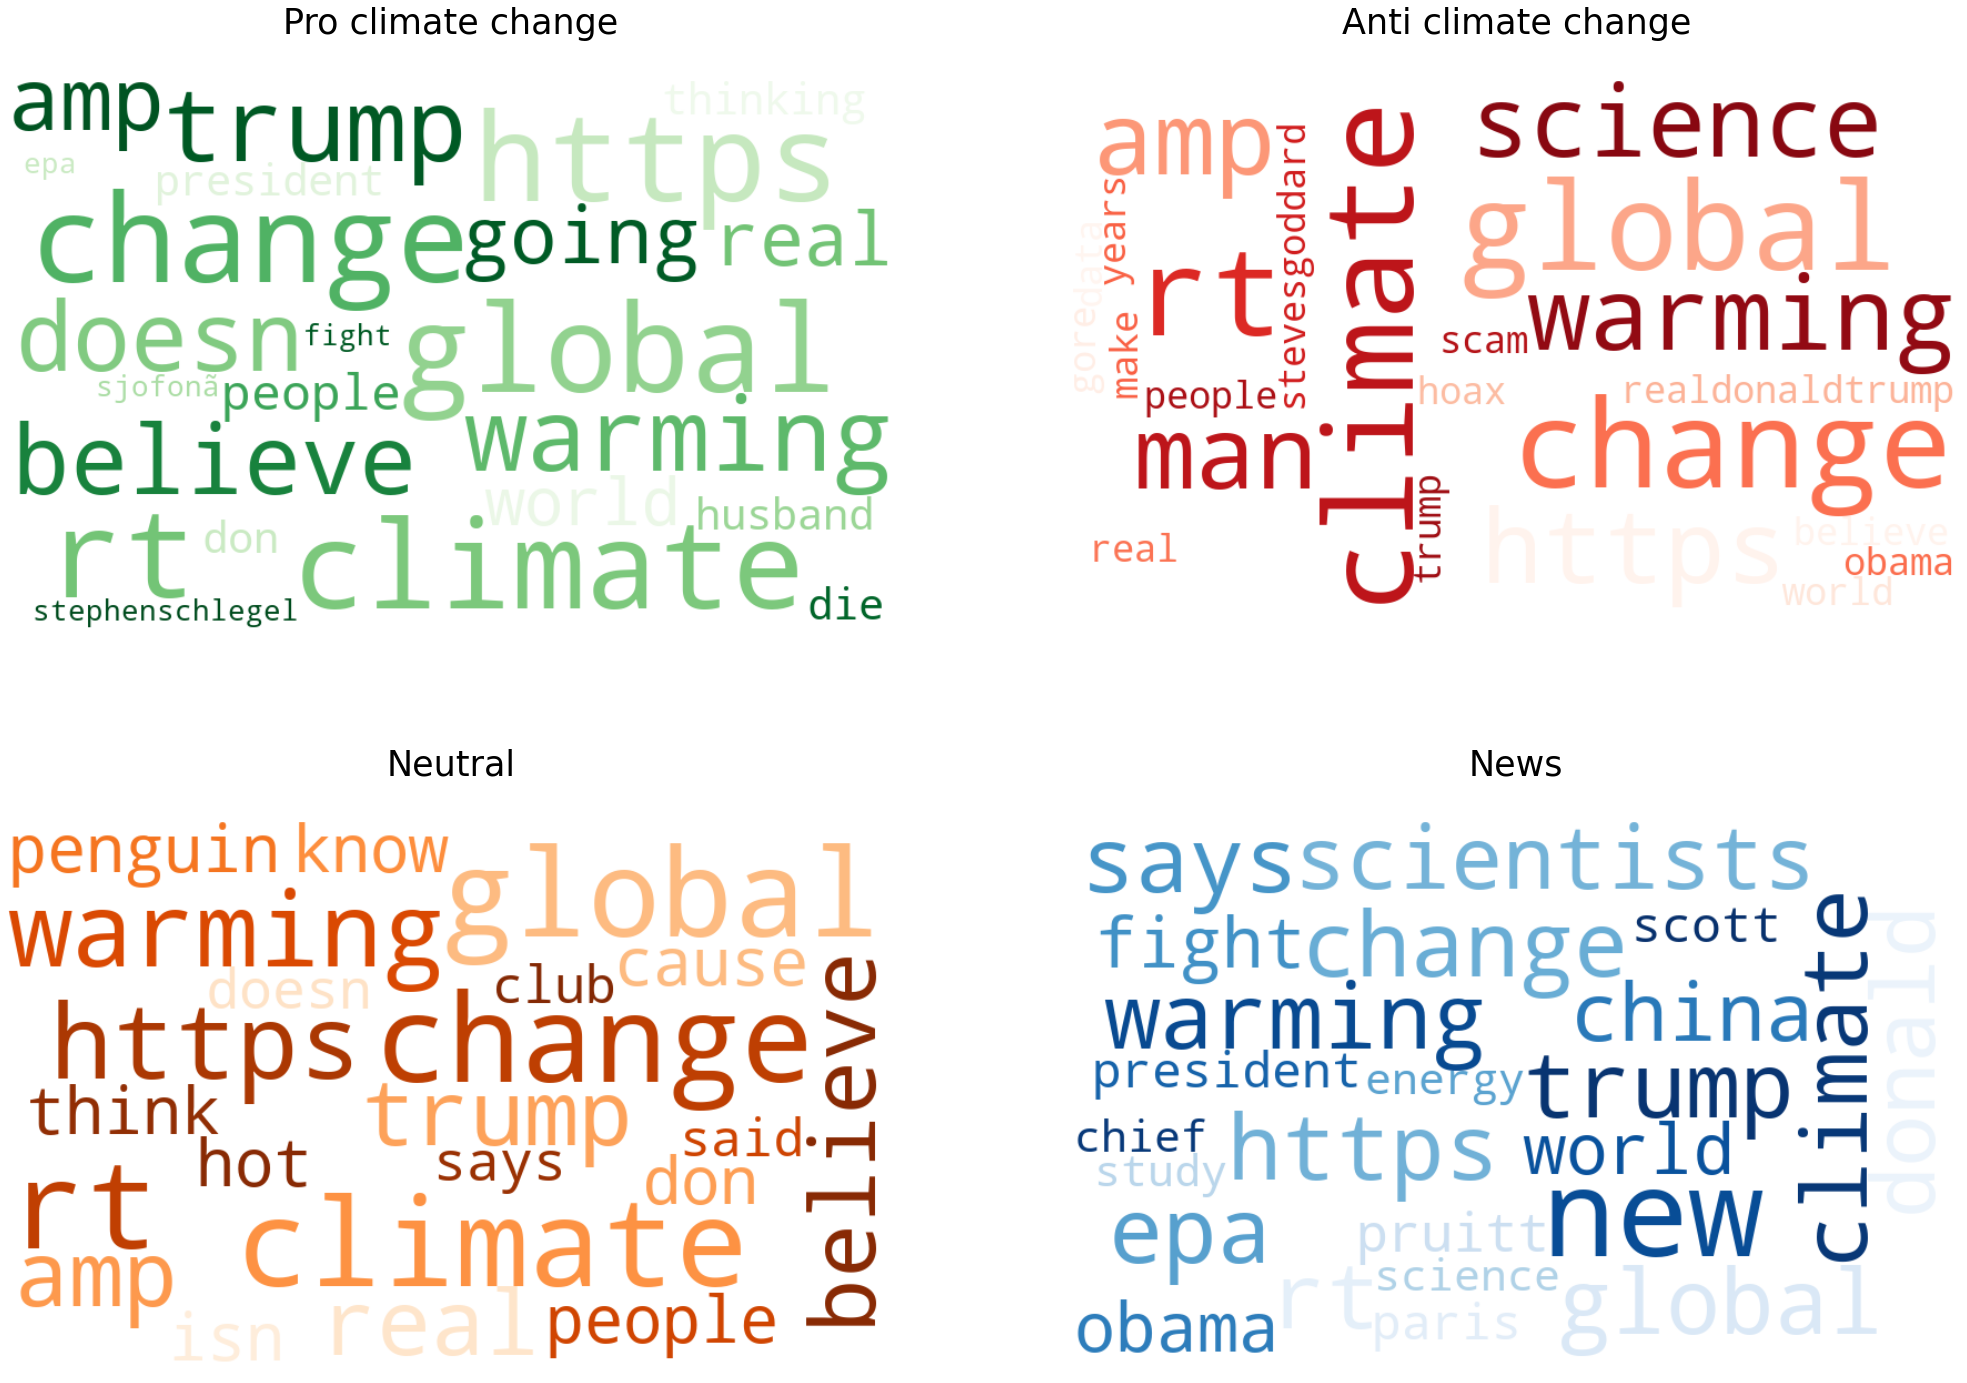

Pro climate change buzzwords 20-25 shown here for clarity


,word,freq
20,husband,312
21,stephenschlegel,307
22,sjofonã,307
23,epa,290
24,fight,288


In [30]:
# Plot pro and anti wordclouds next to one another for comparisson
f, axarr = plt.subplots(2,2, figsize=(35,25))
axarr[0,0].imshow(positive_wordcloud, interpolation="bilinear")
axarr[0,1].imshow(negative_wordcloud, interpolation="bilinear")
axarr[1,0].imshow(neutral_wordcloud, interpolation="bilinear")
axarr[1,1].imshow(news_wordcloud, interpolation="bilinear")

# Remove the ticks on the x and y axes
for ax in f.axes:
    plt.sca(ax)
    plt.axis('off')

axarr[0,0].set_title('Pro climate change\n', fontsize=35)
axarr[0,1].set_title('Anti climate change\n', fontsize=35)
axarr[1,0].set_title('Neutral\n', fontsize=35)
axarr[1,1].set_title('News\n', fontsize=35)
#plt.tight_layout()
plt.show()

print("Pro climate change buzzwords 20-25 shown here for clarity")
display(positive_frequency.tail())

### Resample

In [51]:
from sklearn.utils import resample
class_size = int(len(train_data[train_data['sentiment']==1]))

In [52]:
# seperating the four classes
class_1 = train_data[train_data['sentiment']==-1]
class_2 = train_data[train_data['sentiment']==0]
class_3 = train_data[train_data['sentiment']==1]
class_4 = train_data[train_data['sentiment']==2]

In [53]:
# upsampling classes 1, 2, and 4 & downsampling class 3
class_1_up = resample(class_1,replace=True,n_samples=class_size, random_state=27)
class_2_up = resample(class_2,replace=True,n_samples=class_size, random_state=27)
class_4_up = resample(class_4,replace=True,n_samples=class_size, random_state=27)
class_3_down = resample(class_3,replace=False,n_samples=class_size, random_state=27)


In [54]:
resampled_df = pd.concat([class_1_up, class_2_up, class_4_up,class_3_down])

In [201]:
working_df = resampled_df.copy()
# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

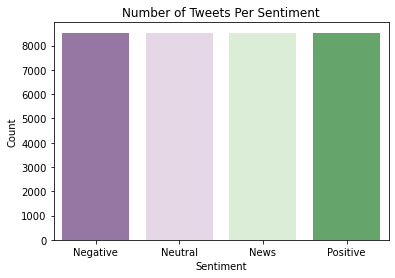

In [202]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Tweets Per Sentiment')

plt.show()

## Training

In [55]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(resampled_df['message'], resampled_df["sentiment"], test_size = 0.2, random_state = 42)


In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Adding rare hashtags as stop words
stopwords = ['p2', 'copp22', 'china', 'parisagreement', 'news', 'sience', 'trump']
count_vect = CountVectorizer()
vectorizer = TfidfVectorizer(stop_words= stopwords,  ngram_range = (1,3), analyzer = 'word')

In [57]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('vectorizer', vectorizer), 
                 ('NB', MultinomialNB(alpha=1.0))])

In [106]:
SVC?

In [107]:
pipe_SVC = Pipeline([('vectorizer', vectorizer), 
                 ('SVC', SVC(gamma=2, C=1))])

In [58]:
pipe.fit(x_train, y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 3),
                                 stop_words=['p2', 'copp22', 'china',
                                             'parisagreement', 'news', 'sience',
                                             'trump'])),
                ('NB', MultinomialNB())])

In [ ]:
pipe_SVC.fit(x_train, y_train)

In [208]:
y_pred = pipe_SVC.predict(x_test)

In [59]:
y_pred_1 = pipe.predict(x_test)

In [ ]:
f1 = f1_score(y_test, y_pred, average= 'weighted')
f1

In [61]:
from sklearn.metrics import classification_report

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.99      1.00      1707
           0       0.99      0.95      0.97      1722
           1       0.90      0.96      0.93      1724
           2       0.97      0.94      0.95      1671

    accuracy                           0.96      6824
   macro avg       0.96      0.96      0.96      6824
weighted avg       0.96      0.96      0.96      6824



In [62]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

          -1       0.88      0.99      0.93      1707
           0       0.92      0.95      0.93      1722
           1       0.94      0.69      0.80      1724
           2       0.87      0.98      0.92      1671

    accuracy                           0.90      6824
   macro avg       0.90      0.90      0.90      6824
weighted avg       0.90      0.90      0.90      6824



## Predictions Test Set


We implement the same preprocessing we applied on our train dataset, now onto our test dataset.

In [38]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r''
test['message'] = test['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [39]:
test['message'] = test['message'].apply(cleanTxt)

In [42]:
test['message'].shape

(10546,)

In [112]:
predictions = pipe_SVC.predict(test['message'])

In [97]:
final_result = pd.DataFrame({'tweetid':test['tweetid'],'sentiment':predictions})
final_result.to_csv('Output10.csv',index=False)

In [47]:
final_result.head()

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0


In [ ]:
experiment.end()